In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

import meteors as mt

from clip_utils import load_base_clip, download

# Always try to set the seed for repeatability :)
torch.manual_seed(0)

In [2]:
download_root = os.path.expanduser("~/.cache/clip")
num_classes = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
model = load_base_clip(download_root=download_root, class_num=num_classes)
vit_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt",
    download_root,
    error_checksum=False,
)
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
model = model.to(device)

In [4]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    padded = np.pad(
        data,
        ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),
        "constant",
        constant_values=0.0,
    )
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask

def load_single_npy_image(image_path):
    data = np.load(image_path)
    data = _shape_pad(data)
    data = data.transpose((1, 2, 0))
    data = data / 5419
    return data


def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            transforms.Resize((image_shape, image_shape)),
        ]
    )

In [5]:
with open("data/wavelenghts.txt", "r") as f:
    wavelengths = f.readline()
wavelengths = [float(wave.strip()) for wave in wavelengths.split(",")]

In [6]:
eval_tr = get_eval_transform(224)

In [7]:
original_predictions = []
numbers_original = []
dataset = os.listdir("../../../pineapple/original_soil_data/soil_data/test")
for image in sorted(dataset, key=lambda x: int(x.split("/")[-1].split(".")[0])):
    numbers_original.append(int(image.split(".")[0]))
    data, _ = load_single_npz_image(f"../../../pineapple/original_soil_data/soil_data/test/{image}")
    image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))
    original_predictions.append(model(image_torch.unsqueeze(0).to(device)).detach().cpu().numpy())

In [8]:
noised_predictions = []
numbers_noised = []
dataset = os.listdir("../../../pineapple/test_data_150_gaussian_pa_0.1_pb_1.0_std_0.01_mean_0.0")
for image in sorted(dataset, key=lambda x: int(x.split("/")[-1].split(".")[0])):
    numbers_noised.append(int(image.split(".")[0]))
    data = load_single_npy_image(f"../../../pineapple/test_data_150_gaussian_pa_0.1_pb_1.0_std_0.01_mean_0.0/{image}")
    image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))
    noised_predictions.append(model(image_torch.unsqueeze(0).to(device)).detach().cpu().numpy())

In [9]:
original_predictions = np.concatenate(original_predictions)
noised_predictions = np.concatenate(noised_predictions)

np.save("original_predictions.npy", original_predictions)
np.save("test_data_150_gaussian_pa_0.1_pb_1.0_std_0.01_mean_0.0.npy", noised_predictions)
original_predictions.shape, noised_predictions.shape

((1154, 4), (1019, 4))

In [10]:
original_predictions_noised = original_predictions[numbers_noised,:]
assert original_predictions_noised.shape == noised_predictions.shape
original_predictions_noised.shape, noised_predictions.shape

((1019, 4), (1019, 4))

In [29]:
errors_per_class.shape

(1019, 4)

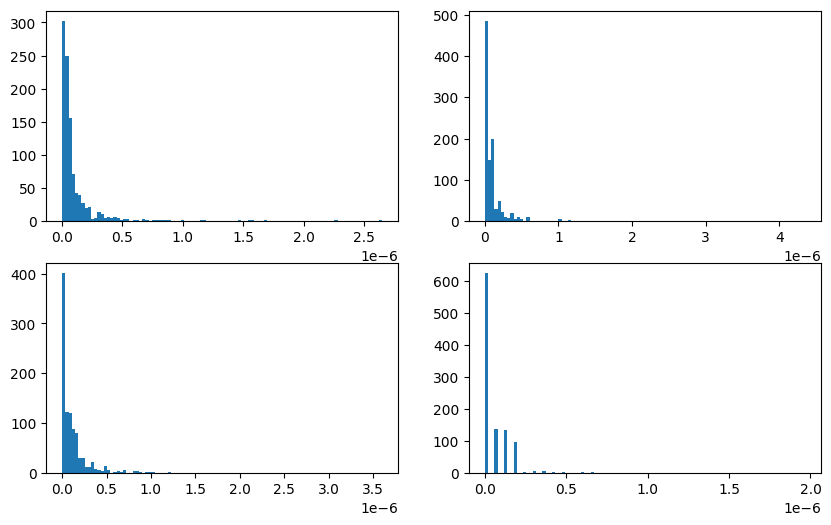

In [ ]:
errors_per_class = np.abs(original_predictions_noised - noised_predictions)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0,0].hist(errors_per_class[:,0], bins=100)
axs[1,0].hist(errors_per_class[:,1], bins=100)
axs[0,1].hist(errors_per_class[:,2], bins=100)
axs[1,1].hist(errors_per_class[:,3], bins=100)

plt.show()

In [35]:
fb, sb, tb, lb = np.argmax(errors_per_class, axis=0).tolist()
sum(errors_per_class[fb]), sum(errors_per_class[sb]), sum(errors_per_class[tb]), sum(errors_per_class[lb])

(1.0520219802856445e-05,
 6.690621376037598e-06,
 1.0520219802856445e-05,
 8.210539817810059e-06)

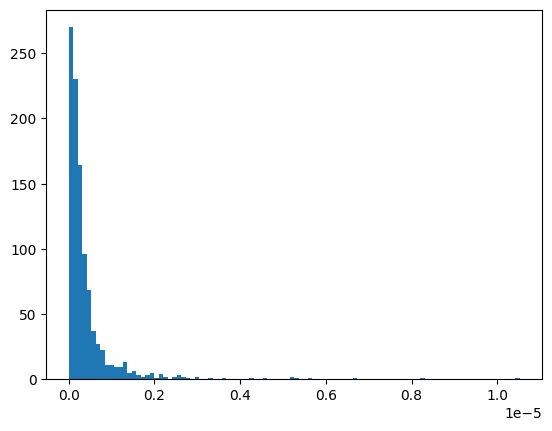

In [36]:
errors = np.sum(np.abs(original_predictions_noised - noised_predictions), axis=1)
plt.hist(errors, bins=100)
plt.show()

In [37]:
diff = np.argsort(errors)
print(f"Biggest diff: {diff[-1]} wth value {original_predictions_noised[diff[-1]]-noised_predictions[diff[-1]]}: {original_predictions_noised[diff[-1]]} - {noised_predictions[diff[-1]]}")
print(f"Smallest diff: {diff[0]} wth value {original_predictions_noised[diff[0]]-noised_predictions[diff[0]]}: {original_predictions_noised[diff[0]]} - {noised_predictions[diff[0]]}")

Biggest diff: 135 wth value [-2.6524067e-06  2.3245811e-06  4.3511391e-06 -1.1920929e-06]: [0.1992669  0.3486109  0.38941827 0.8774137 ] - [0.19926955 0.34860858 0.38941392 0.8774149 ]
Smallest diff: 412 wth value [0. 0. 0. 0.]: [0.19712488 0.34912285 0.3915929  0.8755972 ] - [0.19712488 0.34912285 0.3915929  0.8755972 ]


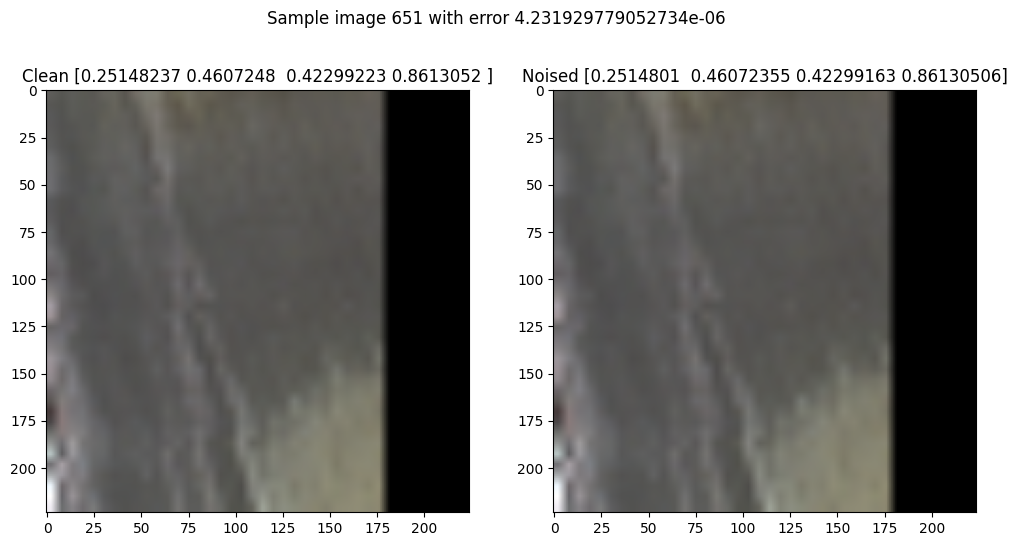

In [38]:
idx = diff[-9]

clean_data = load_single_npz_image(f"../../../pineapple/original_soil_data/soil_data/test/{numbers_noised[idx]}.npz")[0]
clean_data = eval_tr(torch.from_numpy(clean_data.astype(np.float32)).permute(2, 0, 1))
noised_data = load_single_npy_image(f"../../../pineapple/test_data_150_gaussian_pa_0.1_pb_1.0_std_0.01_mean_0.0/{numbers_noised[idx]}.npz.npy")
noised_data = eval_tr(torch.from_numpy(noised_data.astype(np.float32)).permute(2, 0, 1))

clean_hsi = mt.HSI(image=clean_data, wavelengths=wavelengths, orientation="CWH", device=device)
noised_hsi = mt.HSI(image=noised_data, wavelengths=wavelengths, orientation="CWH", device=device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

mt.visualize.visualize_hsi(clean_hsi, ax1, use_mask=True)
ax1.set_title(f"Clean {original_predictions_noised[idx]}")

mt.visualize.visualize_hsi(noised_hsi, ax2, use_mask=True)
ax2.set_title(f"Noised {noised_predictions[idx]}")

fig.suptitle(f"Sample image {idx} with error {errors[idx]}")
plt.show()

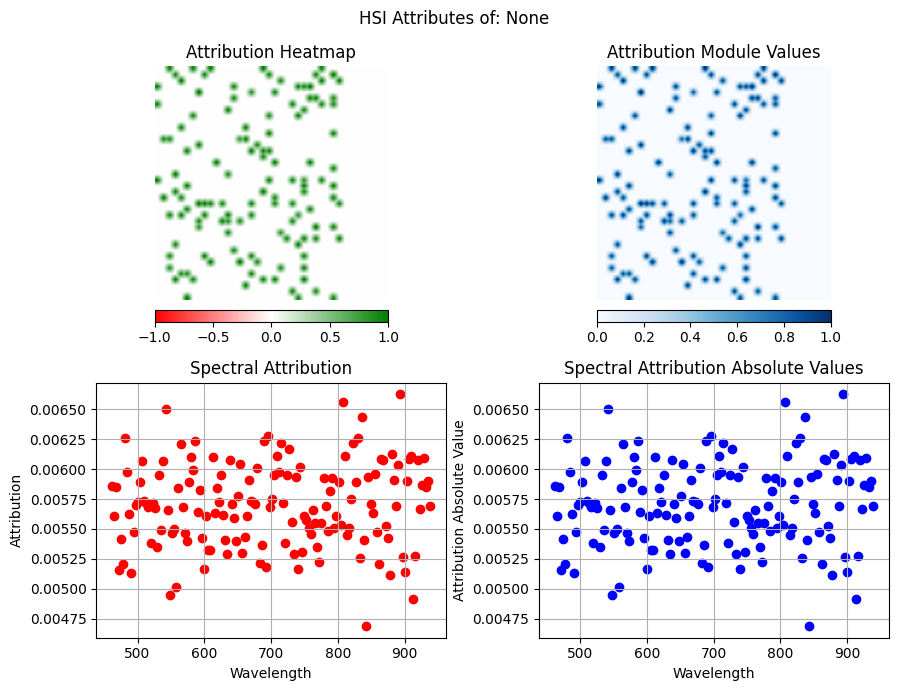

In [41]:
hsi_diff = torch.abs(clean_data - noised_data)
diff_ig_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=hsi_diff,
    device=device,
)
mt.visualize.visualize_attributes(diff_ig_attr, use_pyplot=True)

In [42]:
explainable_model = mt.models.ExplainableModel(model, "regression")
ig = mt.attr.IntegratedGradients(explainable_model)
base_attr = mt.attr.InputXGradient(explainable_model)
nt_attr = mt.attr.NoiseTunnel(base_attr)
hnt_attr = mt.attr.HyperNoiseTunnel(base_attr)

Convergence Delta: 0.00028124702582350836


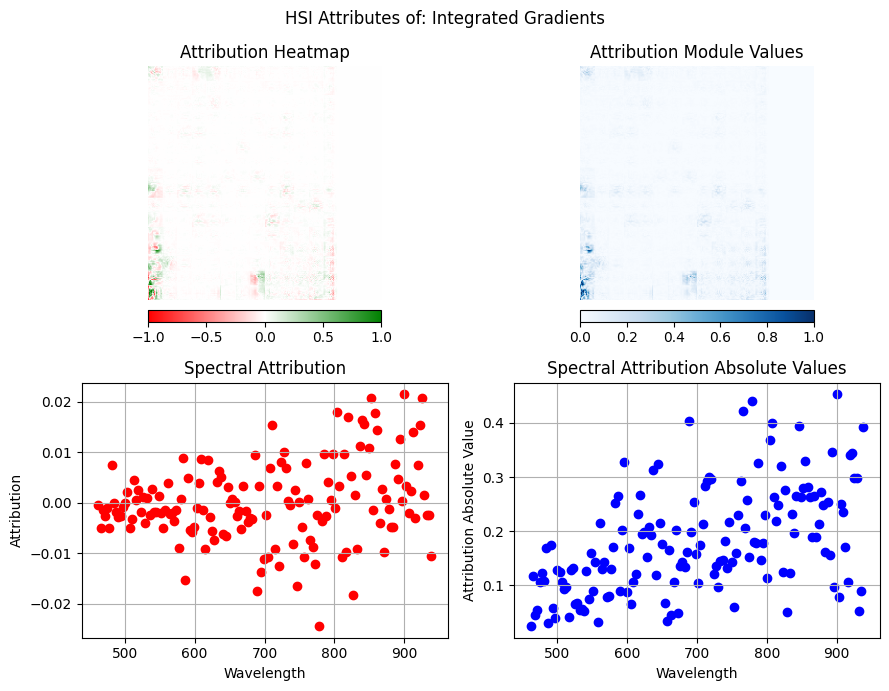

In [43]:
clean_ig_attr = ig.attribute(clean_hsi,target=0,baseline=0.0,return_convergence_delta=True,n_steps=100, internal_batch_size=1)
print(f"Convergence Delta: {clean_ig_attr.score}")
mt.visualize.visualize_attributes(clean_ig_attr, use_pyplot=True)

Convergence Delta: 0.0002845986375698273


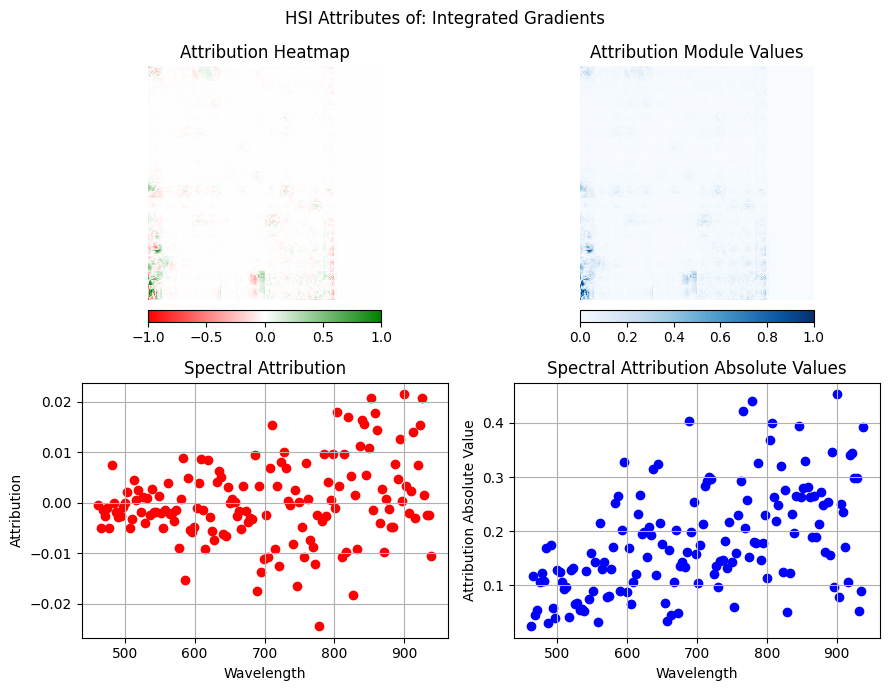

In [44]:
noise_ig_attr = ig.attribute(noised_hsi,target=0,baseline=0.0,return_convergence_delta=True,n_steps=100,internal_batch_size=10)
print(f"Convergence Delta: {noise_ig_attr.score}")
mt.visualize.visualize_attributes(noise_ig_attr, use_pyplot=True)

Overlap between Data changed and Attention changed 0.4507227838039398


/Users/vladimirzaigrajew/Documents/projects/meteors/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(
/Users/vladimirzaigrajew/Documents/projects/meteors/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


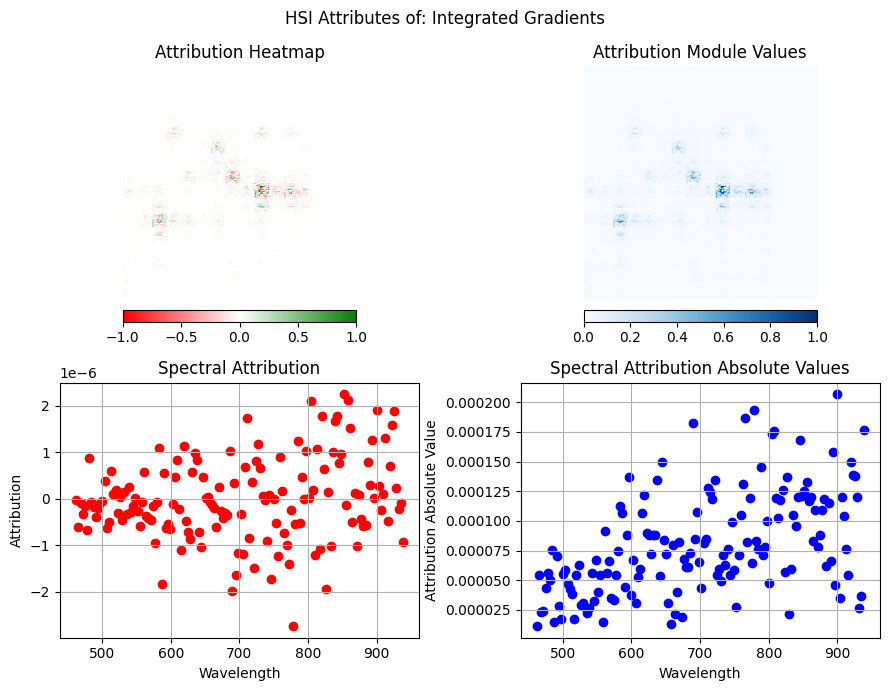

In [47]:
attr_diff = torch.abs(clean_ig_attr.attributes - noise_ig_attr.attributes)
diff_ig_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=clean_ig_attr.attributes - noise_ig_attr.attributes,
    attribution_method=noise_ig_attr.attribution_method,
    score=noise_ig_attr.score,
    device=device,
)
overlap = ((hsi_diff != 0) == (attr_diff != 0)).float().mean()
print(f"Overlap between Data changed and Attention changed {overlap}")
mt.visualize.visualize_attributes(diff_ig_attr, use_pyplot=True)

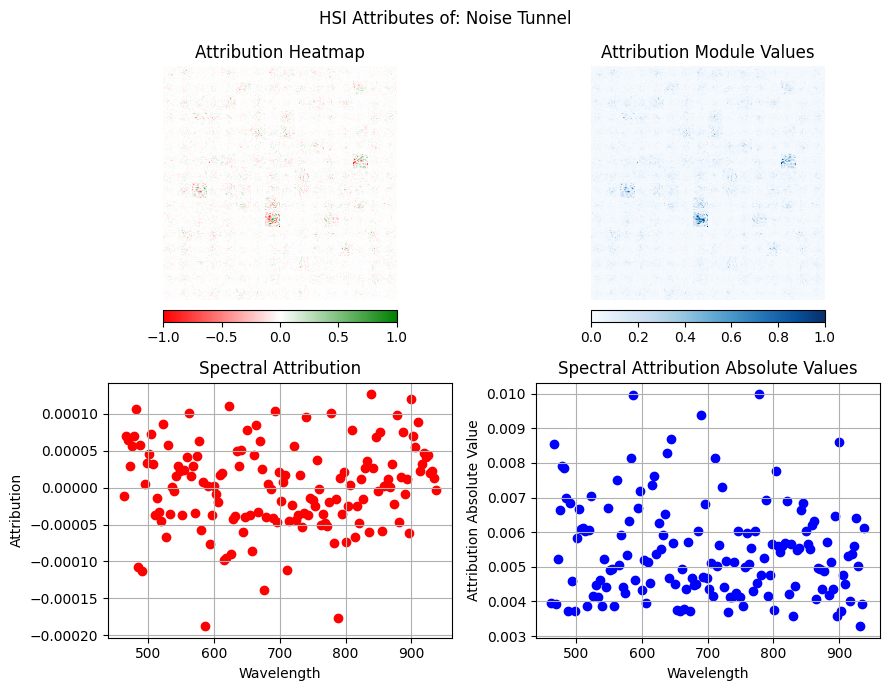

In [48]:
clean_nt_att = nt_attr.attribute(clean_hsi, target=0, n_samples=100, steps_per_batch=10)
mt.visualize.visualize_attributes(clean_nt_att, use_pyplot=True)

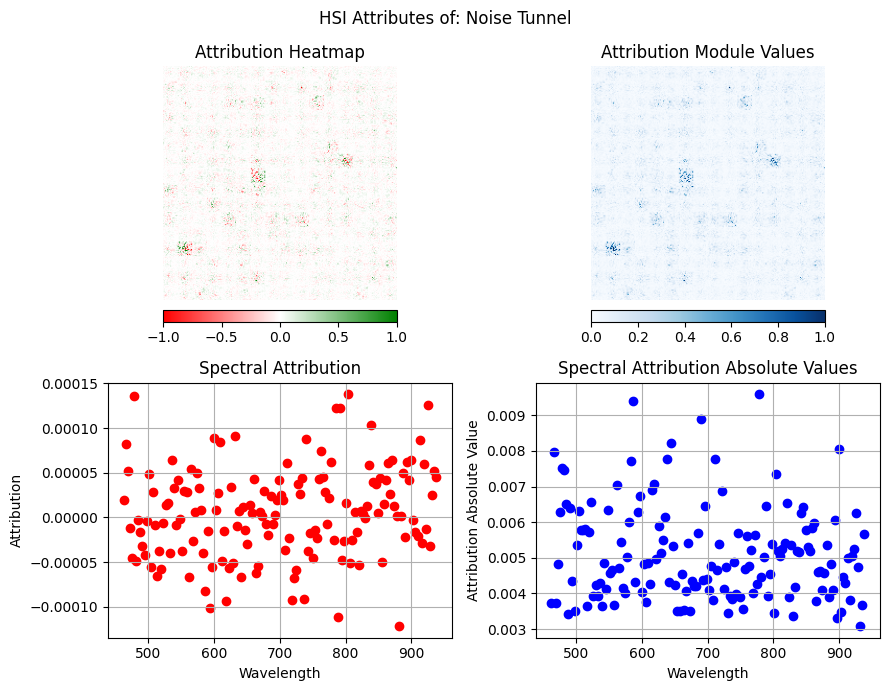

In [49]:
noised_nt_att = nt_attr.attribute(noised_hsi, target=0, n_samples=100, steps_per_batch=10)
mt.visualize.visualize_attributes(noised_nt_att, use_pyplot=True)

Overlap between Data changed and Attention changed 0.2632227838039398


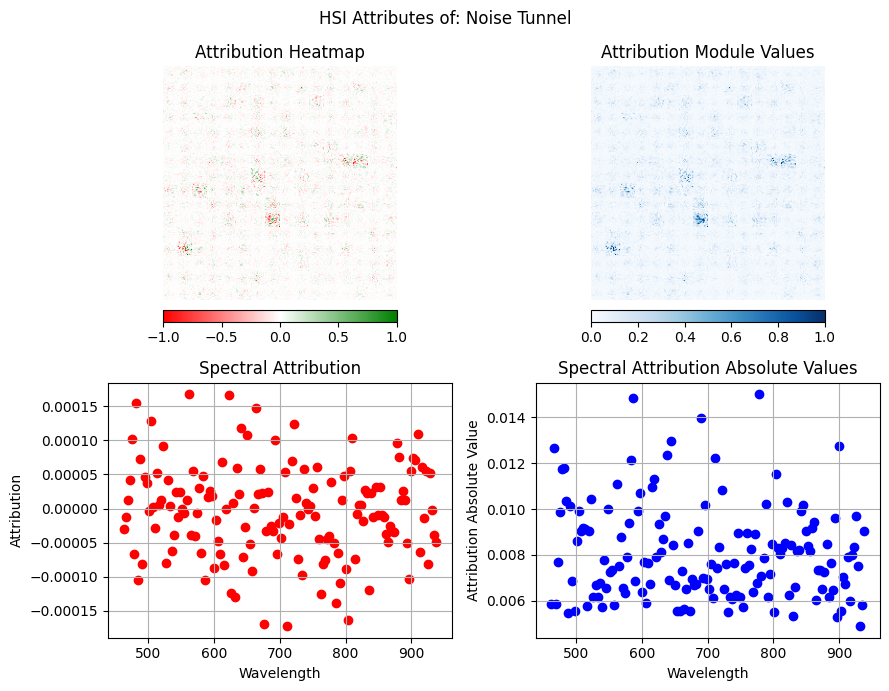

In [50]:
attr_diff = torch.abs(clean_nt_att.attributes - noised_nt_att.attributes)
diff_nt_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=clean_nt_att.attributes - noised_nt_att.attributes,
    attribution_method=noised_nt_att.attribution_method,
    score=noised_nt_att.score,
    device=device,
)
overlap = ((hsi_diff != 0) == (attr_diff != 0)).float().mean()
print(f"Overlap between Data changed and Attention changed {overlap}")
mt.visualize.visualize_attributes(diff_nt_attr, use_pyplot=True)

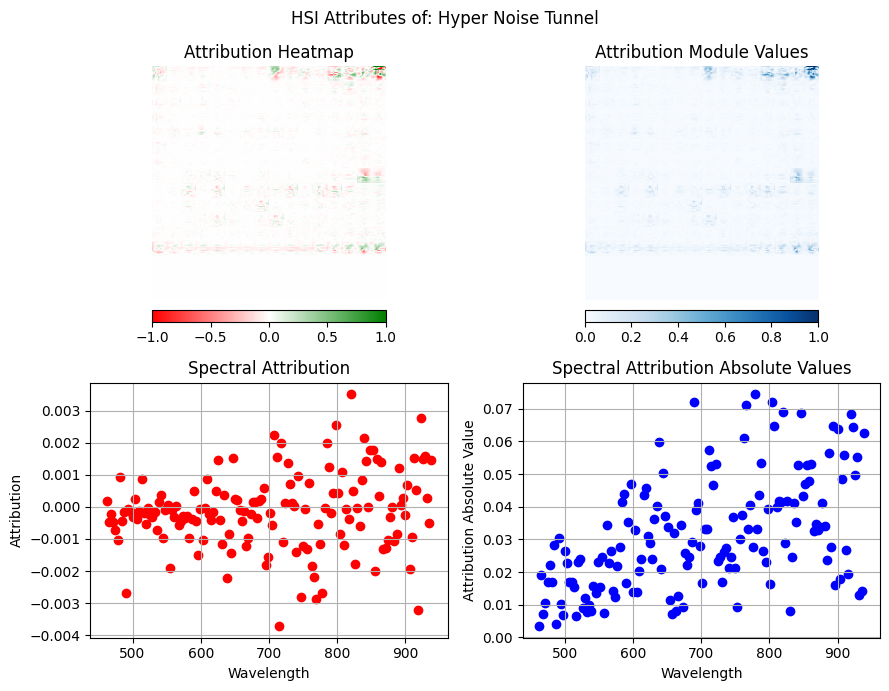

In [51]:
clean_hnt_att = hnt_attr.attribute(clean_hsi, target=0, n_samples=100, baseline=0.0, steps_per_batch=10)
mt.visualize.visualize_attributes(clean_hnt_att, use_pyplot=True)

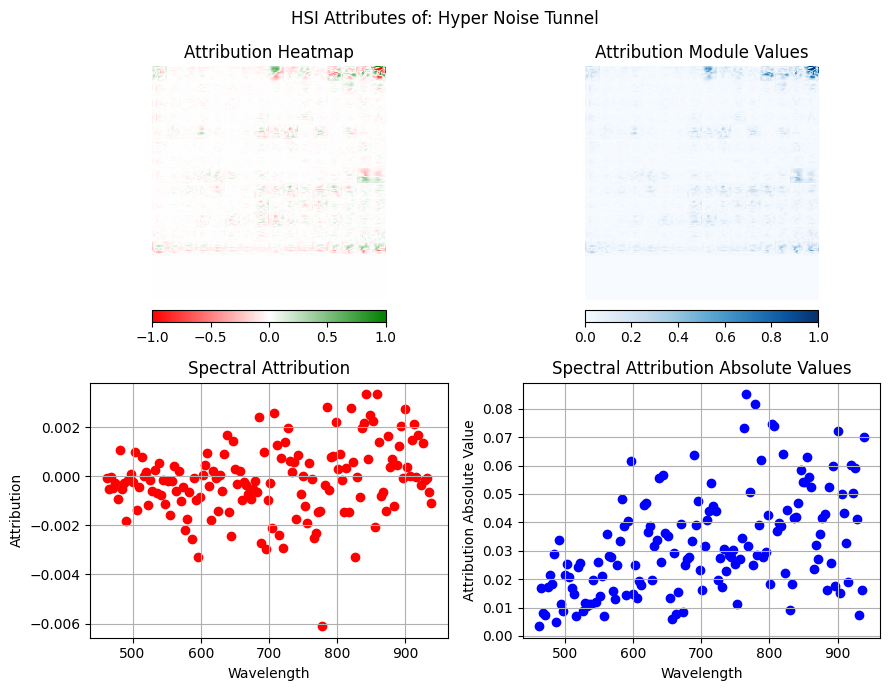

In [52]:
noised_hnt_att = hnt_attr.attribute(noised_hsi, target=0, n_samples=100, baseline=0.0, steps_per_batch=10)
mt.visualize.visualize_attributes(noised_hnt_att, use_pyplot=True)

Overlap between Data changed and Attention changed 0.35895979404449463


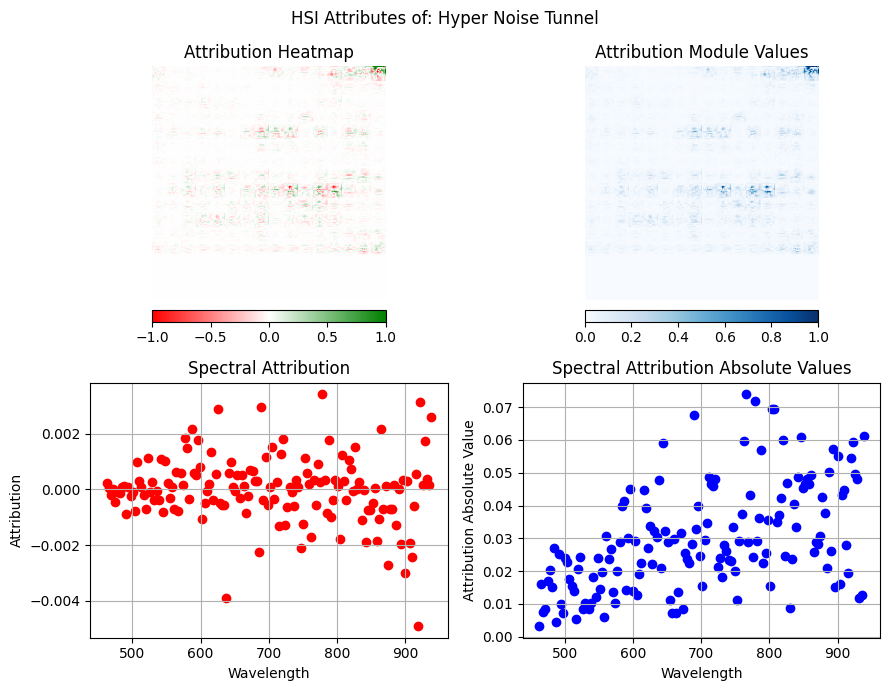

In [53]:
attr_diff = torch.abs(clean_hnt_att.attributes - noised_hnt_att.attributes)
diff_hnt_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=clean_hnt_att.attributes - noised_hnt_att.attributes,
    attribution_method=noised_hnt_att.attribution_method,
    score=noised_hnt_att.score,
    device=device,
)
overlap = ((hsi_diff != 0) == (attr_diff != 0)).float().mean()
print(f"Overlap between Data changed and Attention changed {overlap}")
mt.visualize.visualize_attributes(diff_hnt_attr, use_pyplot=True)

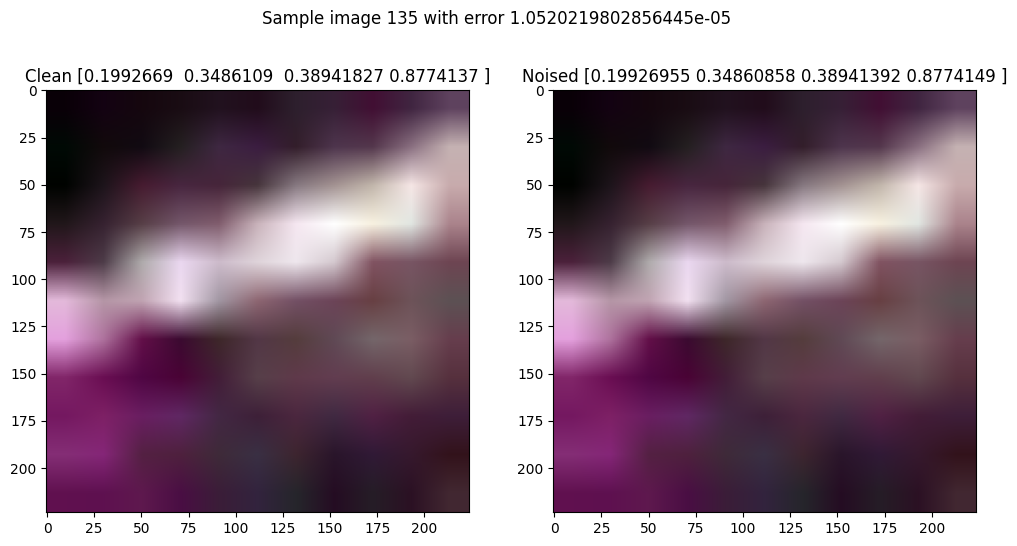

In [54]:
idx = 135

clean_data = load_single_npz_image(f"../../../pineapple/original_soil_data/soil_data/test/{numbers_noised[idx]}.npz")[0]
clean_data = eval_tr(torch.from_numpy(clean_data.astype(np.float32)).permute(2, 0, 1))
noised_data = load_single_npy_image(f"../../../pineapple/test_data_150_gaussian_pa_0.1_pb_1.0_std_0.01_mean_0.0/{numbers_noised[idx]}.npz.npy")
noised_data = eval_tr(torch.from_numpy(noised_data.astype(np.float32)).permute(2, 0, 1))

clean_hsi = mt.HSI(image=clean_data, wavelengths=wavelengths, orientation="CWH", device=device)
noised_hsi = mt.HSI(image=noised_data, wavelengths=wavelengths, orientation="CWH", device=device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

mt.visualize.visualize_hsi(clean_hsi, ax1, use_mask=True)
ax1.set_title(f"Clean {original_predictions_noised[idx]}")

mt.visualize.visualize_hsi(noised_hsi, ax2, use_mask=True)
ax2.set_title(f"Noised {noised_predictions[idx]}")

fig.suptitle(f"Sample image {idx} with error {errors[idx]}")
plt.show()

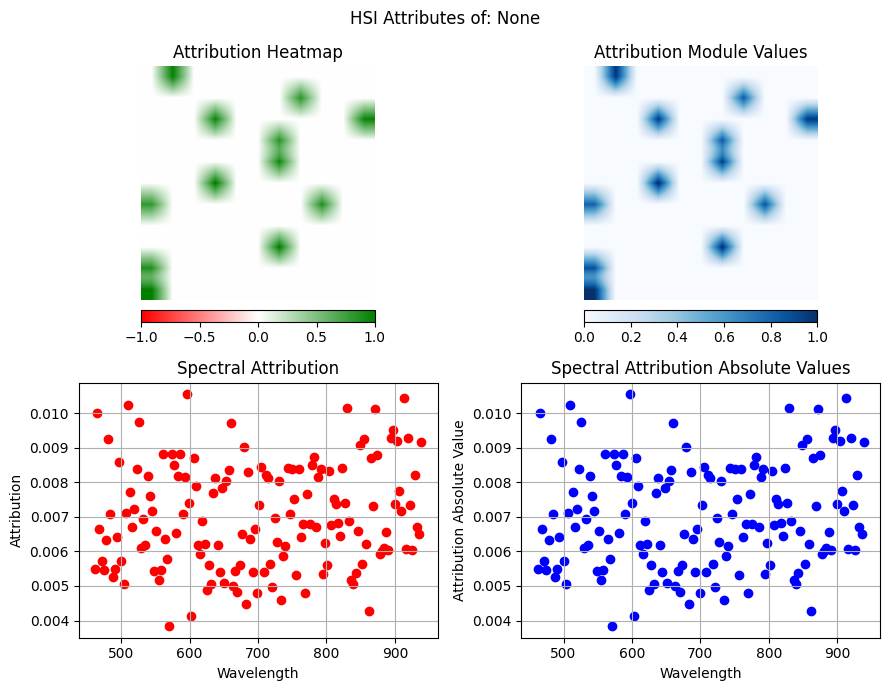

In [55]:
hsi_diff = torch.abs(clean_data - noised_data)
diff_ig_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=hsi_diff,
    device=device,
)
mt.visualize.visualize_attributes(diff_ig_attr, use_pyplot=True)

Convergence Delta: 0.00973229612168109


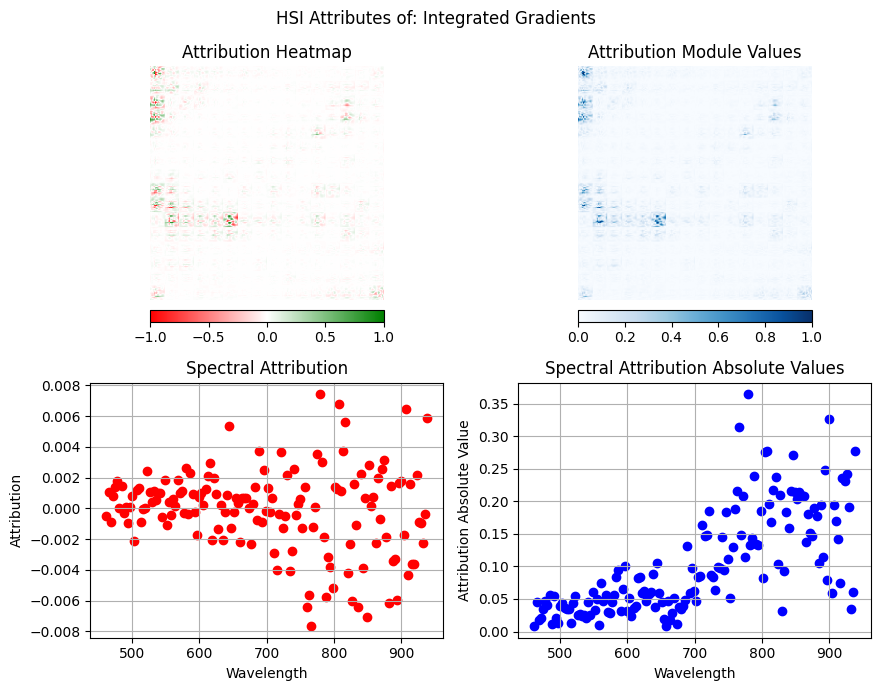

In [56]:
clean_ig_attr = ig.attribute(clean_hsi,target=0,baseline=0.0,return_convergence_delta=True,n_steps=100, internal_batch_size=1)
print(f"Convergence Delta: {clean_ig_attr.score}")
mt.visualize.visualize_attributes(clean_ig_attr, use_pyplot=True)

Convergence Delta: 0.00970455877784273


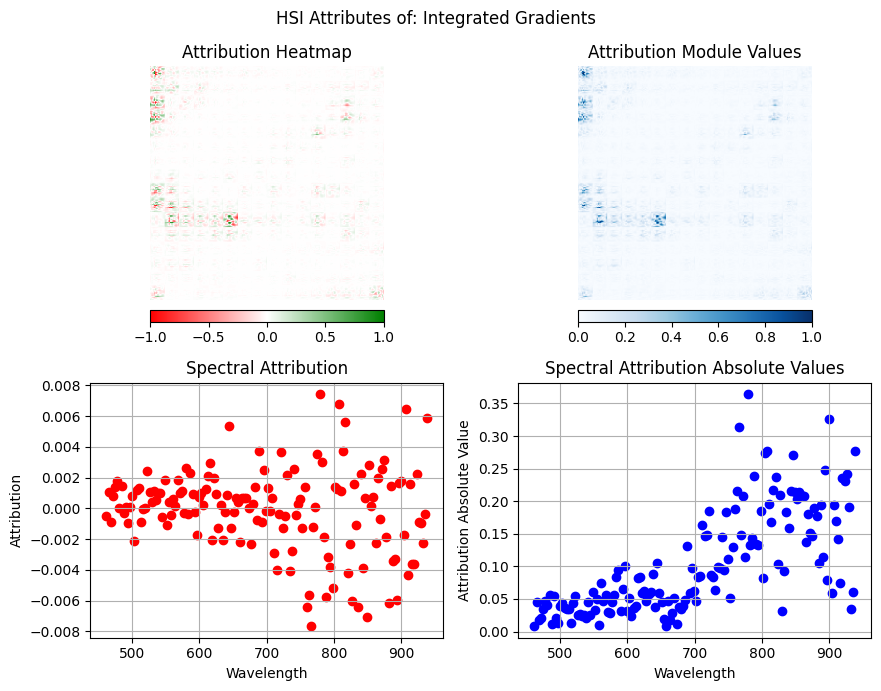

In [57]:
noise_ig_attr = ig.attribute(noised_hsi,target=0,baseline=0.0,return_convergence_delta=True,n_steps=100,internal_batch_size=10)
print(f"Convergence Delta: {noise_ig_attr.score}")
mt.visualize.visualize_attributes(noise_ig_attr, use_pyplot=True)

Overlap between Data changed and Attention changed 0.2896873652935028


/Users/vladimirzaigrajew/Documents/projects/meteors/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(
/Users/vladimirzaigrajew/Documents/projects/meteors/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


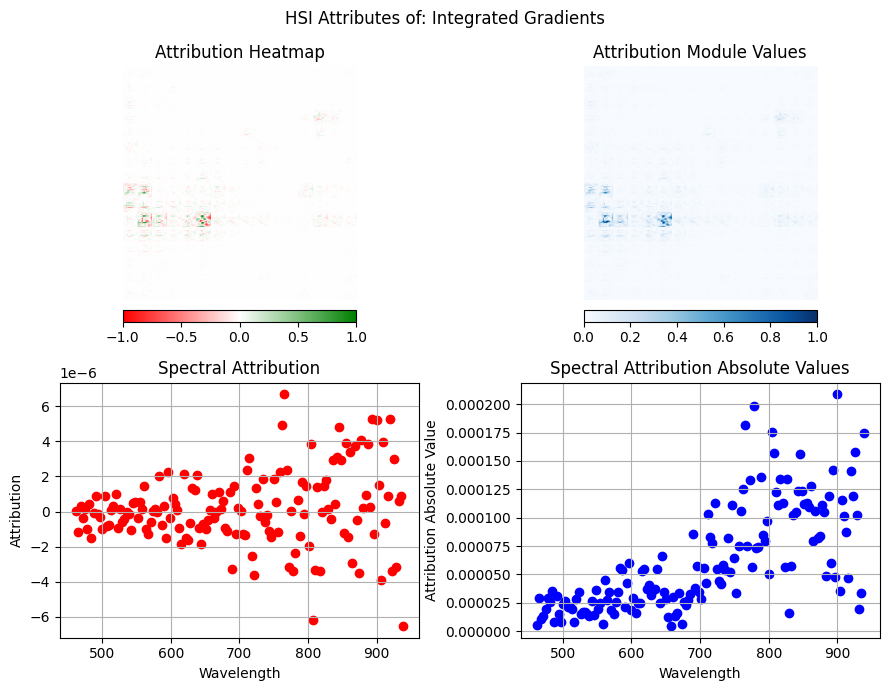

In [58]:
attr_diff = torch.abs(clean_ig_attr.attributes - noise_ig_attr.attributes)
diff_ig_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=clean_ig_attr.attributes - noise_ig_attr.attributes,
    attribution_method=noise_ig_attr.attribution_method,
    score=noise_ig_attr.score,
    device=device,
)
overlap = ((hsi_diff != 0) == (attr_diff != 0)).float().mean()
print(f"Overlap between Data changed and Attention changed {overlap}")
mt.visualize.visualize_attributes(diff_ig_attr, use_pyplot=True)

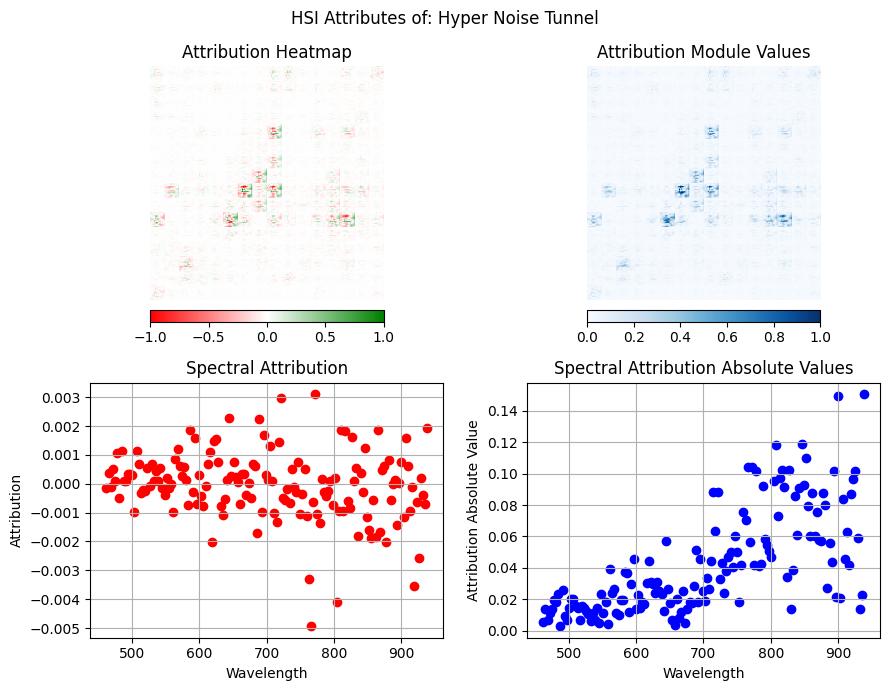

In [59]:
clean_hnt_att = hnt_attr.attribute(clean_hsi, target=0, n_samples=100, baseline=0.0, steps_per_batch=10)
mt.visualize.visualize_attributes(clean_hnt_att, use_pyplot=True)

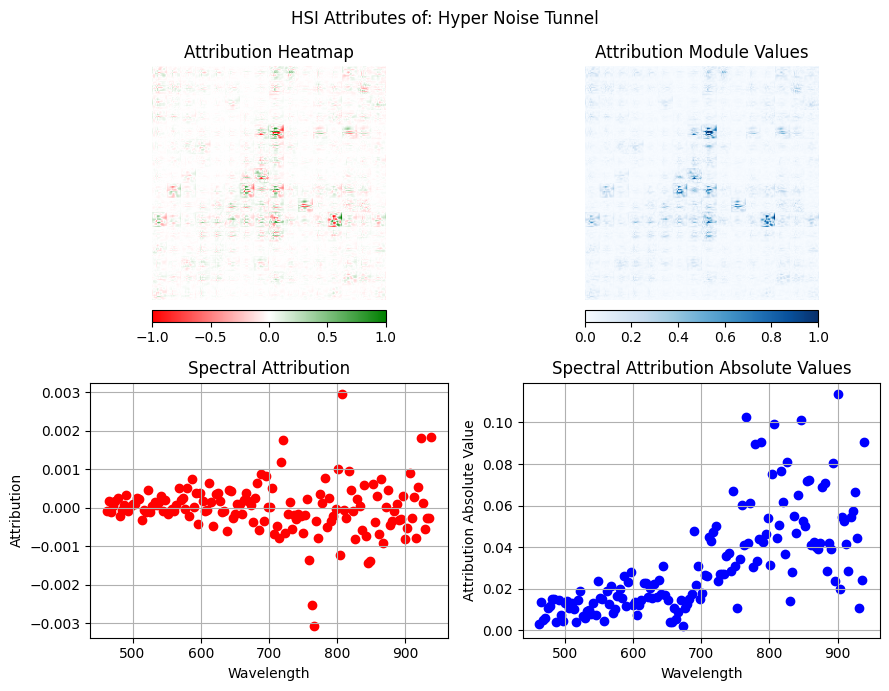

In [60]:
noised_hnt_att = hnt_attr.attribute(noised_hsi, target=0, n_samples=100, baseline=0.0, steps_per_batch=10)
mt.visualize.visualize_attributes(noised_hnt_att, use_pyplot=True)

Overlap between Data changed and Attention changed 0.2896873652935028


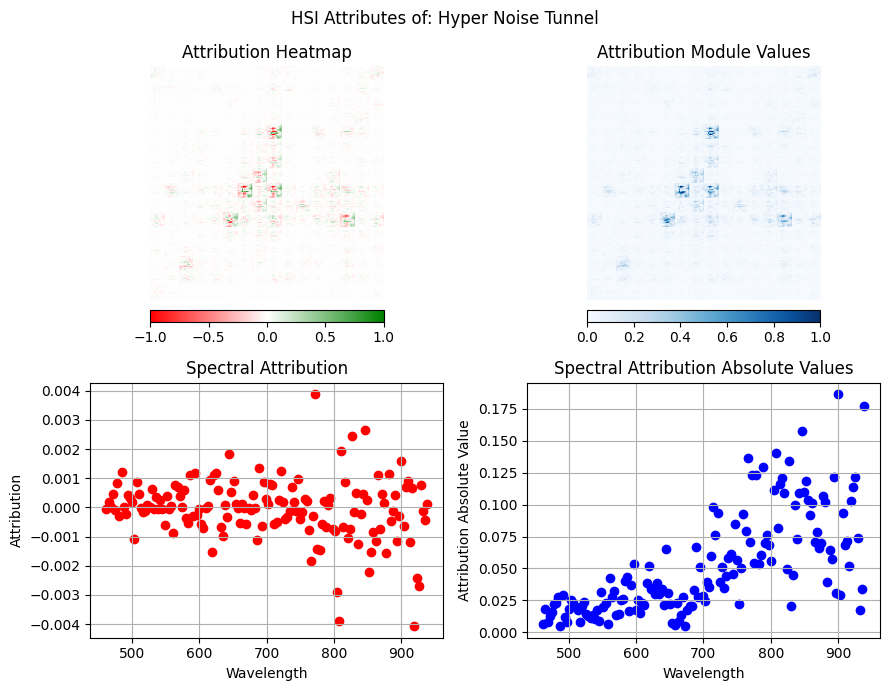

In [61]:
attr_diff = torch.abs(clean_hnt_att.attributes - noised_hnt_att.attributes)
diff_hnt_attr = mt.attr.HSIAttributes(
    hsi=noised_hsi,
    attributes=clean_hnt_att.attributes - noised_hnt_att.attributes,
    attribution_method=noised_hnt_att.attribution_method,
    score=noised_hnt_att.score,
    device=device,
)
overlap = ((hsi_diff != 0) == (attr_diff != 0)).float().mean()
print(f"Overlap between Data changed and Attention changed {overlap}")
mt.visualize.visualize_attributes(diff_hnt_attr, use_pyplot=True)